In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
from sklearn.metrics import mean_squared_error
from math import sqrt
import gc

In [2]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
PWD = r"C:\Users\Desktop\Sales"
preprocessed_data_file = "all_data_lag.csv"
test_file = os.path.join(PWD, "test.csv")

test_df = pd.read_csv(test_file)
all_data = pd.read_csv(os.path.join(PWD, preprocessed_data_file))
all_data = downcast_dtypes(all_data)

In [4]:
def rmse(vec1, vec2):
    return sqrt(mean_squared_error(vec1, vec2))

In [5]:
all_data.head()

,shop_id,item_id,date_block_num,target,target_lag-01,target_shop_lag-01,target_item_lag-01,target_lag-02,target_shop_lag-02,target_item_lag-02,...,date_shop_avg_target_lag-02,date_shop_avg_target_lag-03,date_shop_avg_target_lag-06,date_shop_avg_target_lag-12,date_item_category_avg_target_lag-01,date_shop_item_category_avg_target_lag-01,item_shop_first_sale,item_first_sale,month,days
0,54,10297,12,4.0,3.0,10055.0,42.0,0.0,7978.0,2.0,...,0.9863,0.0000,0.0000,0.0,0.2340,0.6010,2,2,0,31
1,54,10296,12,3.0,0.0,10055.0,24.0,0.0,0.0,0.0,...,0.0000,0.0000,0.0000,0.0,0.2438,0.5520,1,1,0,31
2,54,10298,12,14.0,21.0,10055.0,369.0,119.0,7978.0,1309.0,...,0.9863,0.8306,0.0000,0.0,0.3090,0.9520,3,3,0,31
3,54,10300,12,3.0,1.0,10055.0,54.0,31.0,7978.0,361.0,...,0.9863,0.8306,0.0000,0.0,0.2340,0.6010,3,3,0,31
4,54,10284,12,1.0,0.0,10055.0,4.0,0.0,7978.0,3.0,...,0.9863,0.8306,0.8594,0.0,0.1383,0.4553,10,10,0,31


In [6]:
target_date = 34

In [7]:
val_date = 33

In [8]:
train_X = all_data[all_data["date_block_num"] < val_date].copy()
train_y = train_X["target"]
train_X_date_block_num = train_X["date_block_num"]
train_X.drop(["target", "date_block_num"], axis=1, inplace=True)

In [9]:
test_X = all_data[all_data['date_block_num'] == target_date].copy()
test_X.head()
test_X.drop(["target", "date_block_num"], axis=1, inplace=True)

In [10]:
val_X = all_data[all_data["date_block_num"] == val_date].copy()
val_y = val_X["target"]
val_X_date_block_num = val_X["date_block_num"]
val_X.drop(["target", "date_block_num"], axis=1, inplace=True)

In [11]:
cate_cols = ["shop_id",
             "item_id",             
             "item_category_id",
             "month",
             "days"]
             
lgbm_categorical_feature_str = "name:{}".format(','.join(cate_cols))

In [12]:
import lightgbm as lgb


In [13]:
lgb_params = {
    'max_depth' : 8,
    'n_estimators' : 1000,
    'min_child_weight' : 300, 
    'colsample_bytree' : 0.8, 
    'subsample' : 0.8, 
    'eta' : 0.1,
    'verbose' : 1,
    'seed' : 42,
    'nthread' : 4,
    'early_stopping_round':10,
    'metric' : 'rmse',
    'objective' : 'regression'
}

In [14]:
lgb_train_data = lgb.Dataset(train_X, train_y.clip(0,20))
lgb_val_data = lgb.Dataset(val_X, val_y, reference=lgb_train_data)

In [15]:
evals_result = {} # for plotting
lgb_model = lgb.train(lgb_params, lgb_train_data, 300, 
                      valid_sets=lgb_val_data, 
                      verbose_eval=True, evals_result=evals_result)

/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:102: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 2.66897
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 2.64579
[3]	valid_0's rmse: 2.62633
[4]	valid_0's rmse: 2.60988
[5]	valid_0's rmse: 2.59605
[6]	valid_0's rmse: 2.58468
[7]	valid_0's rmse: 2.57319
[8]	valid_0's rmse: 2.56343
[9]	valid_0's rmse: 2.55538
[10]	valid_0's rmse: 2.54866
[11]	valid_0's rmse: 2.54241
[12]	valid_0's rmse: 2.53661
[13]	valid_0's rmse: 2.53108
[14]	valid_0's rmse: 2.52627
[15]	valid_0's rmse: 2.52167
[16]	valid_0's rmse: 2.51862
[17]	valid_0's rmse: 2.51488
[18]	valid_0's rmse: 2.51185
[19]	valid_0's rmse: 2.50944
[20]	valid_0's rmse: 2.50735
[21]	valid_0's rmse: 2.50556
[22]	valid_0's rmse: 2.50358
[23]	valid_0's rmse: 2.50152
[24]	valid_0's rmse: 2.49929
[25]	valid_0's rmse: 2.49836
[26]	valid_0's rmse: 2.49752
[27]	valid_0's rmse: 2.49629
[28]	valid_0's rmse: 2.49538
[29]	valid_0's rmse: 2.49485
[30]	valid_0's rmse: 2.49409
[31]	valid_0's rmse: 2.49319
[32]	valid_0's rmse: 2.49215
[33]	valid_0's rmse

In [16]:
lgb_pred_val_y = lgb_model.predict(val_X)

In [17]:
r = rmse(lgb_pred_val_y.clip(0,20), val_y.values.clip(0,20))
print("RMSE:", r)

RMSE: 0.9043416440413741


In [18]:
best_iteration = lgb_model.current_iteration()
print("best iteration:", best_iteration)

best iteration: 127


In [19]:
a = np.hstack([val_y.values.reshape(-1,1), lgb_pred_val_y.reshape(-1,1)])

level2_train_df = pd.DataFrame(a, columns=["target", "gbm"])
level2_train_df.head()

,target,gbm
0,1.0,0.003950
1,1.0,0.671648
2,2.0,0.461039
3,1.0,0.110168
4,1.0,0.685280


In [20]:
level2_train_df.to_csv('level2_train_gbm.csv', index=False)

In [21]:
train_X = all_data[all_data["date_block_num"] < target_date].copy()
train_y = train_X["target"]
train_X_date_block_num = train_X["date_block_num"]
train_X.drop(["target", "date_block_num"], axis=1, inplace=True)

In [22]:
all_data = None
val_X = None
val_y = None
gc.collect()

74

In [23]:
lgb_train_ds = lgb.Dataset(train_X, train_y)
lgb_model = lgb.train(lgb_params, lgb_train_ds, best_iteration)
lgb_pred_y = lgb_model.predict(test_X)

In [24]:
lgb_pred_y_df = pd.DataFrame(lgb_pred_y.clip(0,20))
lgb_pred_y_df.columns = ["item_cnt_month"]
lgb_pred_y_df.to_csv("lgb_gbm_prediction.csv", header=True, index=True, index_label="ID")

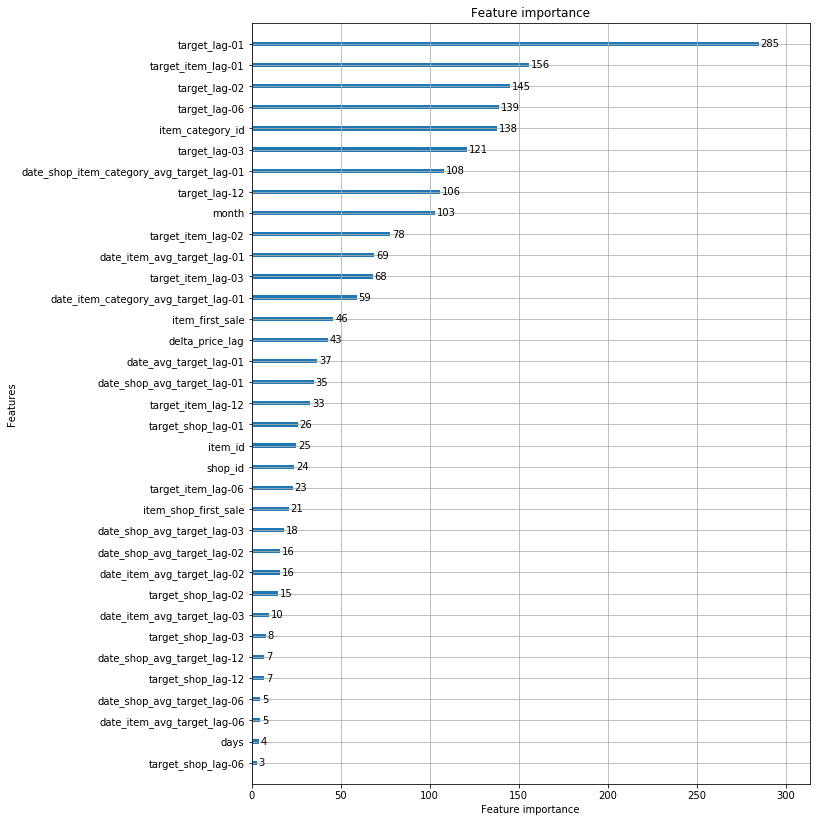

In [25]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return lgb.plot_importance(booster=booster, ax=ax)

plot_features(lgb_model, (10,14))